In [1]:
'''
This routine detects heatwave events across the entire spatial grid using the 95th percentile threshold, generating a dataset with event flags, magnitudes, and anomalies.

Daniela Risaro
July 2025
'''


'\nThis routine detects heatwave events across the entire spatial grid using the 95th percentile threshold, generating a dataset with event flags, magnitudes, and anomalies.\n\nDaniela Risaro\nJuly 2025\n'

In [2]:
import xarray as xr
import numpy as np 
import pandas as pd
import os 


In [3]:
def detect_events(arr_bool, amount_days=5):
    result = np.zeros_like(arr_bool, dtype=np.int8)
    count = 0
    for i in range(len(arr_bool)):
        if arr_bool[i]:
            count += 1
        else:
            if count >= amount_days:
                result[i - count:i] = 1
            count = 0
    if count >= amount_days:
        result[len(arr_bool) - count:] = 1
    return result

In [4]:

data_processed_dir = "../data/processed/"
data_raw_dir = "../data/raw/"

region = [6, -74, -34, -33]

climatology_years = [1995, 2024]
file_percentiles = f'tmax2m_mean_and_percentiles_{climatology_years[0]}_{climatology_years[1]}_area_{region[0]}N_{region[1]}W_{region[2]}S_{region[3]}E.nc'
files_raw = sorted([file for file in os.listdir(data_raw_dir) if file.endswith(".nc")])

ds_percentiles = xr.open_dataset(data_processed_dir + file_percentiles)

# --- Recorte espacial São Paulo ---
lat_min, lat_max = -25.4, -19.7
lon_min, lon_max = -53.25, -44

if ds_percentiles.latitude[0] > ds_percentiles.latitude[-1]:
    ds_percentiles = ds_percentiles.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
else:
    ds_percentiles = ds_percentiles.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
# ----------------------------------

percentile = 98 
p_percentile = ds_percentiles[f't2m_p{percentile}']


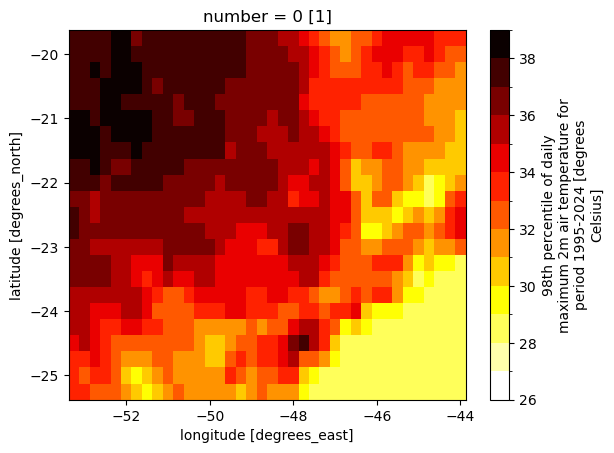

In [5]:
p_percentile_mean = p_percentile.round(0)
p_percentile_mean.plot(levels=np.arange(26, 40, 1), cmap='hot_r')

In [6]:


list_years = np.arange(2010, 2026) 

amount_days = [3, 5, 7]  # Durations to analyze

for iamount in amount_days:
    list_datasets = []
     
    for year in list_years:

        print(f"Processing year {year}")

        variable = "tmax"
        file_year = [
            f for f in files_raw
            if variable in f and all(str(abs(coord)) in f for coord in region) and f"_{year}_" in f
        ]
        if not file_year:
            print(f"No se encontró archivo para {year}")
            continue

        ds_year = xr.open_dataset(os.path.join(data_raw_dir, file_year[0]))

        # --- Recorte espacial São Paulo ---
        if ds_year.latitude[0] > ds_year.latitude[-1]:
            ds_year = ds_year.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
        else:
            ds_year = ds_year.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
        # ----------------------------------

        ds_year = ds_year["t2m"] - 273.15

        time_len = ds_year.sizes["valid_time"]
        lat_len = len(ds_percentiles.latitude)
        lon_len = len(ds_percentiles.longitude)

        dummy_all = np.zeros((time_len, lat_len, lon_len), dtype=np.int8)
        magnitude_all = np.full((time_len, lat_len, lon_len), np.nan, dtype=np.float32)
        anomaly_all = np.full((time_len, lat_len, lon_len), np.nan, dtype=np.float32)

        for lat_idx in range(lat_len):
            for lon_idx in range(lon_len):
                target_year_point = ds_year.isel(latitude=lat_idx, longitude=lon_idx)
                p_percentile_point = p_percentile_mean.isel(latitude=lat_idx, longitude=lon_idx)
                threshold = p_percentile_point

                excess = target_year_point - threshold
                exceeds = excess > 0

                dummy = detect_events(exceeds.values, amount_days=iamount)
                dummy_all[:, lat_idx, lon_idx] = dummy
                magnitude_all[:, lat_idx, lon_idx] = target_year_point.where(dummy == 1).values
                anomaly_all[:, lat_idx, lon_idx] = excess.where(dummy == 1).values

        ds_out = xr.Dataset(
            {
                "tmax2m": (["valid_time", "latitude", "longitude"], ds_year.values),
                "event_dummy": (["valid_time", "latitude", "longitude"], dummy_all),
                "magnitude_event": (["valid_time", "latitude", "longitude"], magnitude_all),
                "anomaly_event": (["valid_time", "latitude", "longitude"], anomaly_all),
            },
            coords={
                "valid_time": ds_year["valid_time"].values,
                "latitude": ds_year["latitude"].values,
                "longitude": ds_year["longitude"].values
            }
        )

        ds_out = ds_out.expand_dims(year=[year])
        list_datasets.append(ds_out)
        del ds_year, dummy_all, magnitude_all, anomaly_all, ds_out
        del target_year_point, p_percentile_point, threshold, excess, exceeds, dummy

    final_ds = xr.concat(list_datasets, dim="year")

    output_path = os.path.join(data_processed_dir, f"heatwaves_{list_years[0]}_{list_years[-1]}_p{percentile}_threshold_events_{iamount}_days_area_sao_paulo.nc")
    print(f"heatwaves_{list_years[0]}_{list_years[-1]}_p{percentile}_threshold_events_{iamount}_days_area_sao_paulo.nc")
    final_ds.to_netcdf(output_path)
    del final_ds, list_datasets



Processing year 2010
Processing year 2011
Processing year 2012
Processing year 2013
Processing year 2014
Processing year 2015
Processing year 2016
Processing year 2017
Processing year 2018
Processing year 2019
Processing year 2020
Processing year 2021
Processing year 2022
Processing year 2023
Processing year 2024
Processing year 2025
heatwaves_2010_2025_p98_threshold_events_3_days_area_sao_paulo.nc
Processing year 2010
Processing year 2011
Processing year 2012
Processing year 2013
Processing year 2014
Processing year 2015
Processing year 2016
Processing year 2017
Processing year 2018
Processing year 2019
Processing year 2020
Processing year 2021
Processing year 2022
Processing year 2023
Processing year 2024
Processing year 2025
heatwaves_2010_2025_p98_threshold_events_5_days_area_sao_paulo.nc
Processing year 2010
Processing year 2011
Processing year 2012
Processing year 2013
Processing year 2014
Processing year 2015
Processing year 2016
Processing year 2017
Processing year 2018
Process